# Imports

In [53]:
import os
import sys

# Adds project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Adds include folder to find dependencies.py
sys.path.append(os.path.join(project_root, "include"))

import dependencies

from dependencies import *


# Getting Data Locally (update to support collab or other more shareable/cloud based service)

In [54]:

save_outputs_to = r"C:\Users\miles\favela_analysis\output\faz_quem_quer"
site_to_study = r"C:\Users\miles\favela_analysis\site_shps\faz_quem_quer\faz_quem_quer.shp"
site_name = "faz_quem_quer"


In [55]:
# "C:\Users\miles\OneDrive\Desktop\school\UROP\Data\best_test_set.shp"
output_dir = save_outputs_to
try:
    buildings_path = site_to_study #DATA SOURCE GOES HERE
    clean_buildings, tessellation, excluded_buildings, report = perform_perfect_tessellation(
        buildings_path,
        min_area=1.0,
        buffer_dist=100,
        max_iterations=10
    )

    print_perfect_tessellation_report(report)

except Exception as e:
    print(f"Error: {str(e)}")



Tessellation Report:
--------------------------------------------------
Original building count: 4727
Excluded building count: 9
Final building count: 4718
Tessellation cell count: 4718

Reasons for exclusion:
  - too_small: 1 buildings
  - tessellation_failure: 8 buildings


In [56]:
#Initialize calculator and run calculations
calculator = BuildingMetricsCalculator(clean_buildings, tessellation, save_outputs_to) #BuildingMetricsCalculator Class
calculator.run_all_calculations()


c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_distribution.py:285: UserWarning: The indices of the two GeoSeries are different.
  (geoms.distance(geometry.geometry, align=True)).groupby(level=0).mean()
c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_shape.py:576: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(90 - degrees[true_angles]))


# Spatial Joint MM and TP

In [57]:
clean_buildings = clean_buildings.join(tessellation, rsuffix='_tessellation')
clean_buildings = clean_buildings.set_geometry("geometry")


# GROUND TRUTH DATA


=== Favela Classification Analysis ===
Total buildings: 4718
Favela buildings: 1294 (27.4%)
Non-favela buildings: 3424

Building type distribution:
1.0: 1294 buildings


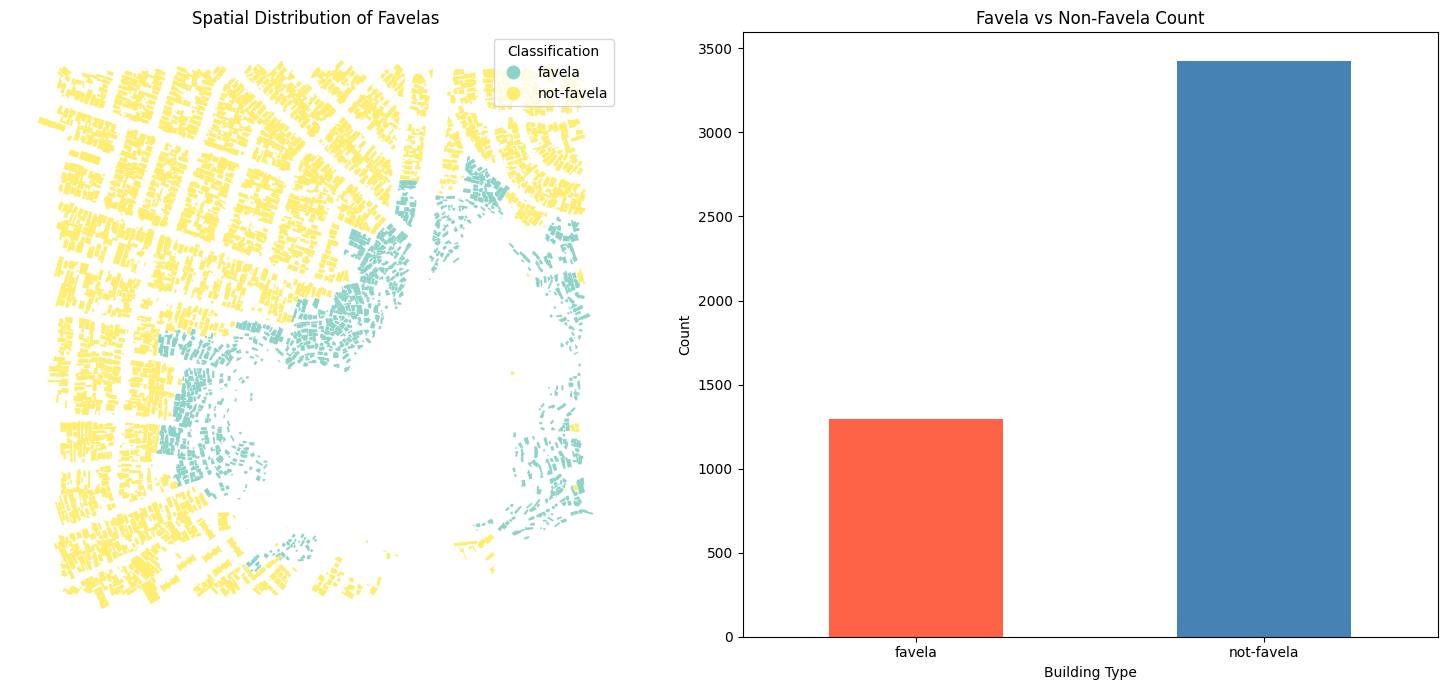

In [58]:
# from ground_truth import classify_and_analyze_favelas

try:
    classified_buildings, analysis = classify_and_analyze_favelas(
        clean_buildings,
        type_column='nome_count'
    )

    ground_truth_gdf = classified_buildings

    # merge buildings
    clean_buildings['label'] = classified_buildings['label']

    plt.show()

except Exception as e:
    print(f"Error during classification analysis: {str(e)}")


# XG Boost Classification

In [59]:
results = run_xgboost(ground_truth_gdf)

# save results
save_xgboost_results(results, save_outputs_to, site_name)

ground_truth_gdf = results['updated_gdf']
metrics = results['metrics']
xgb_model = results['model']
X_imputed = results['X_full_imputed']

print(results['classification_report'])


{'favela': {'precision': 0.9004149377593361, 'recall': 0.8543307086614174, 'f1-score': 0.8767676767676768, 'support': 254.0}, 'not-favela': {'precision': 0.9473684210526315, 'recall': 0.9652173913043478, 'f1-score': 0.9562096195262024, 'support': 690.0}, 'accuracy': 0.9353813559322034, 'macro avg': {'precision': 0.9238916794059838, 'recall': 0.9097740499828826, 'f1-score': 0.9164886481469396, 'support': 944.0}, 'weighted avg': {'precision': 0.9347347507597321, 'recall': 0.9353813559322034, 'f1-score': 0.9348343510297347, 'support': 944.0}}


## Save SHAP Results

In [60]:
shap_results = calculate_shap_results(xgb_model, X_imputed, metrics, ground_truth_gdf)

save_shap_results(shap_results, output_dir, site_name)
